*Install the needed libraries*

In [1]:
!pip install torch torchvision torchaudio monai nibabel matplotlib

In [3]:
import torch
print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.6.0+cpu


In [5]:
!pip install pydicom

In [13]:
def auto_window_volume(volume, lower_percentile=1, upper_percentile=99):
    """
    Scales intensities based on percentiles (better for pre-rescaled data).
    """
    low = np.percentile(volume, lower_percentile)
    high = np.percentile(volume, upper_percentile)
    volume = np.clip(volume, low, high)
    volume = (volume - low) / (high - low)
    return volume.astype(np.float32)

In [15]:
import os
import time
import pydicom
import numpy as np
from scipy.ndimage import zoom

# ✅ Resize while preserving float values
def resize_slice(image, target_size=(128, 128)):
    zoom_factors = (
        target_size[0] / image.shape[0],
        target_size[1] / image.shape[1]
    )
    return zoom(image, zoom_factors, order=1)  # bilinear

# ✅ Fixed brain windowing in Hounsfield Units (ideal for stroke)
def window_volume(volume, center=40, width=80):
    min_val = center - width // 2
    max_val = center + width // 2
    volume = np.clip(volume, min_val, max_val)
    volume = (volume - min_val) / (max_val - min_val)
    return volume.astype(np.float32)

def load_dicom_batch(patient_folder, target_size=(128, 128)):
    """
    Loads and sorts DICOM slices from a patient folder,
    converts to HU, resizes to (128, 128), and stacks to 3D.
    """
    anonymize_path = os.path.join(patient_folder, "Anonymize")
    folder_to_use = anonymize_path if os.path.isdir(anonymize_path) else patient_folder
    dicom_slices = []

    for dicom_file in os.listdir(folder_to_use):
        if dicom_file.endswith('.dcm'):
            dicom_path = os.path.join(folder_to_use, dicom_file)
            try:
                dicom_data = pydicom.dcmread(dicom_path)
                try:
                    sort_key = float(dicom_data.ImagePositionPatient[2])
                except:
                    sort_key = int(dicom_data.InstanceNumber)
                dicom_slices.append((sort_key, dicom_data))
            except Exception as e:
                print(f"⚠️ Skipping corrupt DICOM: {dicom_path} | Error: {e}")
                continue

    dicom_slices.sort(key=lambda x: x[0])

    dicom_images = []
    for _, dicom_data in dicom_slices:
        dicom_image = dicom_data.pixel_array.astype(np.float32)

        # ✅ Convert to Hounsfield Units (HU)
        if 'RescaleSlope' in dicom_data and 'RescaleIntercept' in dicom_data:
            slope = float(dicom_data.RescaleSlope)
            intercept = float(dicom_data.RescaleIntercept)
            dicom_image = dicom_image * slope + intercept

        # ✅ Resize without converting to 8-bit
        resized_image = resize_slice(dicom_image, target_size)
        dicom_images.append(resized_image)

    return np.stack(dicom_images, axis=0) if dicom_images else None

def process_directory(directory_path, batch_size=8):
    for disease_folder in os.listdir(directory_path):
        disease_folder_path = os.path.join(directory_path, disease_folder)
        if not os.path.isdir(disease_folder_path):
            continue

        for patient_folder in os.listdir(disease_folder_path):
            patient_folder_path = os.path.join(disease_folder_path, patient_folder)
            if not os.path.isdir(patient_folder_path):
                continue

            print(f"🔹 Processing: {patient_folder} in {disease_folder}")

            volume = load_dicom_batch(patient_folder_path)
            if volume is None:
                print(f"⚠️ No valid DICOM images for {patient_folder}, skipping...")
                continue

            # ✅ Apply fixed brain windowing for better tissue contrast
            volume = window_volume(volume, center=40, width=80)

            # Split into batches
            num_full_batches = len(volume) // batch_size
            for i in range(num_full_batches):
                batch = volume[i * batch_size : (i + 1) * batch_size]
                yield disease_folder, patient_folder, i, batch

            remaining = len(volume) % batch_size
            if remaining > 0:
                batch = volume[-remaining:]
                yield disease_folder, patient_folder, num_full_batches, batch

def convert_and_save_batches(input_directory, output_folder, retry_attempts=3):
    batch_generator = process_directory(input_directory, batch_size=8)
    total_batches = 0

    for disease, patient, batch_index, batch in batch_generator:
        disease_output_folder = os.path.join(output_folder, disease)
        patient_output_folder = os.path.join(disease_output_folder, patient)
        os.makedirs(patient_output_folder, exist_ok=True)

        batch_file_path = os.path.join(patient_output_folder, f'batch_{batch_index}.npy')

        for attempt in range(retry_attempts):
            try:
                with open(batch_file_path, 'wb') as f:
                    np.save(f, batch)
                    f.flush()
                print(f"✅ Saved batch {batch_index} for {patient} ({disease})")
                total_batches += 1
                break
            except TimeoutError as e:
                print(f"❌ Timeout saving {batch_file_path} (Attempt {attempt+1})")
                time.sleep(3)
            except Exception as e:
                print(f"⚠️ Unexpected error: {e} | Skipping batch {batch_index} for {patient}")
                break

    print(f"🎉 Processing complete! Total batches saved: {total_batches}")

# Paths
input_directory = r'D:/ProjectData'
output_directory = r'D:/ResultData'

# Run
convert_and_save_batches(input_directory, output_directory)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:/ProjectData'

In [13]:
import os
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Custom collate function from earlier to pad volumes along the depth dimension.
def pad_collate_fn(batch):
    """
    Custom collate function that pads patient volumes along the depth dimension.
    
    Each item in the batch is a tuple (volume, label), where:
      - volume has shape (1, D, H, W)
      - label is a scalar (e.g., 0 for Normal, 1 for Stroke)
    
    This function finds the maximum depth in the batch and pads all volumes
    along the depth dimension to that size.
    """
    volumes, labels = zip(*batch)  # volumes is a tuple of tensors, labels is a tuple of ints
    # Determine the maximum depth (number of slices) in the batch.
    max_depth = max(volume.shape[1] for volume in volumes)
    
    padded_volumes = []
    for v in volumes:
        current_depth = v.shape[1]
        if current_depth < max_depth:
            pad_size = max_depth - current_depth
            # Create a padding tensor of zeros with shape: (channels, pad_size, height, width)
            pad_tensor = torch.zeros((v.shape[0], pad_size, v.shape[2], v.shape[3]), dtype=v.dtype)
            # Concatenate the original volume with the padding tensor along the depth dimension.
            padded_v = torch.cat([v, pad_tensor], dim=1)
        else:
            padded_v = v
        padded_volumes.append(padded_v)
    
    # Stack the padded volumes along a new batch dimension.
    volumes_tensor = torch.stack(padded_volumes)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return volumes_tensor, labels_tensor

# Custom Dataset class
class PatientVolumeDataset(Dataset):
    def __init__(self, patient_paths, transform=None):
        """
        Args:
            patient_paths (list): List of tuples (patient_folder_path, label).
            transform (callable, optional): Optional transform to apply to a sample.
        """
        self.patient_paths = patient_paths
        self.transform = transform

    def __len__(self):
        return len(self.patient_paths)
    
    def __getitem__(self, idx):
        patient_path, label = self.patient_paths[idx]
        # Get all .npy files in the patient folder (these are the batches)
        batch_files = [f for f in os.listdir(patient_path) if f.endswith('.npy')]
        # Sort files by their batch index (assumes names like "batch_0.npy", "batch_1.npy", etc.)
        batch_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
        
        # Load each batch and collect them in a list
        volume_batches = []
        for file in batch_files:
            file_path = os.path.join(patient_path, file)
            batch_data = np.load(file_path)
            volume_batches.append(batch_data)
        
        # Concatenate all batches along the slice (depth) dimension
        volume = np.concatenate(volume_batches, axis=0)  # shape: (D, H, W)
        # Add channel dimension to get (1, D, H, W)
        volume = np.expand_dims(volume, axis=0)
        
        # Optionally apply any transforms
        if self.transform:
            volume = self.transform(volume)
        
        # Convert to torch tensor (float32)
        volume_tensor = torch.tensor(volume, dtype=torch.float32)
        return volume_tensor, label

# Helper function to get all patient paths and associated labels from the ResultData folder.
def get_patient_paths(root_dir):
    """
    Scans the root directory with structure:
       root_dir/
         Normal/
           patient_1/
           patient_2/
           ...
         Stroke/
           patient_3/
           ...
    Returns a list of tuples: (patient_folder_path, label)
    where label is 0 for Normal and 1 for Stroke.
    """
    patient_paths = []
    for disease in os.listdir(root_dir):
        disease_path = os.path.join(root_dir, disease)
        if os.path.isdir(disease_path):
            # Assign label based on folder name.
            label = 0 if disease.lower() == "normal" else 1
            for patient in os.listdir(disease_path):
                patient_path = os.path.join(disease_path, patient)
                if os.path.isdir(patient_path):
                    patient_paths.append((patient_path, label))
    return patient_paths

# Set the root directory where your processed data is saved.
root_dir = r'D:/ResultData'
all_patient_paths = get_patient_paths(root_dir)
print(f"Total patients found: {len(all_patient_paths)}")

# Shuffle and split into train (80%), validation (10%), and test (10%) sets.
random.shuffle(all_patient_paths)
n = len(all_patient_paths)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

train_paths = all_patient_paths[:n_train]
val_paths = all_patient_paths[n_train:n_train+n_val]
test_paths = all_patient_paths[n_train+n_val:]

print(f"Train patients: {len(train_paths)}")
print(f"Validation patients: {len(val_paths)}")
print(f"Test patients: {len(test_paths)}")

# Create datasets for each split.
train_dataset = PatientVolumeDataset(train_paths)
val_dataset = PatientVolumeDataset(val_paths)
test_dataset = PatientVolumeDataset(test_paths)

# Create DataLoaders with the custom collate function.
dataloader_train = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=pad_collate_fn)
dataloader_val = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=pad_collate_fn)
dataloader_test = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=pad_collate_fn)

# Example: Iterate over the training DataLoader and inspect shapes and labels.
for volume, label in dataloader_train:
    print("Train Volume shape:", volume.shape)  # Expected shape: (batch, 1, max_D, 128, 128)
    print("Train Labels:", label)
    break

Total patients found: 323
Train patients: 258
Validation patients: 32
Test patients: 33
Train Volume shape: torch.Size([4, 1, 66, 128, 128])
Train Labels: tensor([1, 1, 0, 1])


Volume shape: (41, 128, 128)


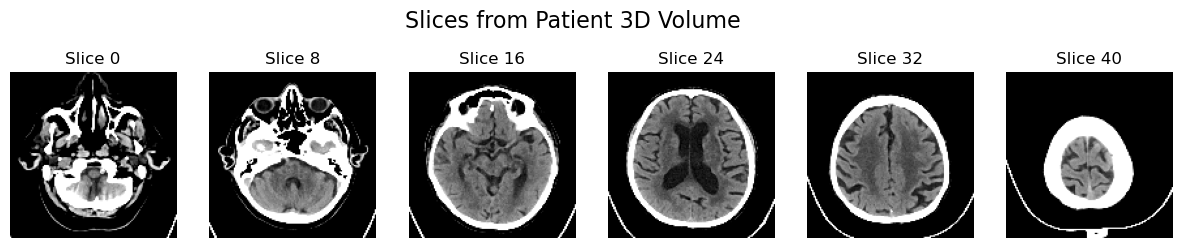

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Set path to one patient's folder
patient_folder = r'D:/ResultData/Stroke/17409'

# 🔹 Get all .npy batch files and sort them
batch_files = [f for f in os.listdir(patient_folder) if f.endswith('.npy')]
batch_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))  # Sort like batch_0, batch_1, ...

# 🔹 Load and stack all batches to build the full volume
slices = []
for f in batch_files:
    batch_path = os.path.join(patient_folder, f)
    batch_data = np.load(batch_path)  # shape: (8, 128, 128) or similar
    slices.append(batch_data)

# 🔹 Combine slices into a 3D array: (depth, height, width)
volume = np.concatenate(slices, axis=0)
print("Volume shape:", volume.shape)  # Expecting (D, 128, 128)

# 🔹 Function to show multiple slices
def show_slices(volume, num_slices=6):
    depth = volume.shape[0]
    indices = np.linspace(0, depth - 1, num_slices, dtype=int)

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_slices, i+1)
        plt.imshow(volume[idx], cmap='gray')
        plt.title(f"Slice {idx}")
        plt.axis('off')
    plt.suptitle("Slices from Patient 3D Volume", fontsize=16)
    plt.show()

# 🔹 Display
show_slices(volume)

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math
from functools import partial

_all_ = [
    'ResNet', 'resnet10', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
    'resnet152', 'resnet200'
]

def conv3x3x3(in_planes, out_planes, stride=1, dilation=1):
    # 3x3x3 convolution with padding
    return nn.Conv3d(
        in_planes,
        out_planes,
        kernel_size=3,
        dilation=dilation,
        stride=stride,
        padding=dilation,
        bias=False)

def downsample_basic_block(x, planes, stride, no_cuda=False):
    out = F.avg_pool3d(x, kernel_size=1, stride=stride)
    zero_pads = torch.Tensor(
        out.size(0), planes - out.size(1), out.size(2), out.size(3),
        out.size(4)).zero_()
    if not no_cuda:
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()
    out = Variable(torch.cat([out.data, zero_pads], dim=1))
    return out

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3x3(inplanes, planes, stride=stride, dilation=dilation)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes, dilation=dilation)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride
        self.dilation = dilation

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = nn.Conv3d(
            planes, planes, kernel_size=3, stride=stride, dilation=dilation, padding=dilation, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.dilation = dilation

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self,
                 block,
                 layers,
                 sample_input_D,
                 sample_input_H,
                 sample_input_W,
                 num_seg_classes,
                 shortcut_type='B',
                 no_cuda=False):
        self.inplanes = 64
        self.no_cuda = no_cuda
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv3d(
            1,
            64,
            kernel_size=7,
            stride=(2, 2, 2),
            padding=(3, 3, 3),
            bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], shortcut_type)
        self.layer2 = self._make_layer(
            block, 128, layers[1], shortcut_type, stride=2)
        self.layer3 = self._make_layer(
            block, 256, layers[2], shortcut_type, stride=1, dilation=2)
        self.layer4 = self._make_layer(
            block, 512, layers[3], shortcut_type, stride=1, dilation=4)
        self.conv_seg = nn.Sequential(
            nn.ConvTranspose3d(
                512 * block.expansion,
                32,
                2,
                stride=2
            ),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.Conv3d(
                32,
                32,
                kernel_size=3,
                stride=(1, 1, 1),
                padding=(1, 1, 1),
                bias=False),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.Conv3d(
                32,
                num_seg_classes,
                kernel_size=1,
                stride=(1, 1, 1),
                bias=False)
        )
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1, dilation=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(
                    downsample_basic_block,
                    planes=planes * block.expansion,
                    stride=stride,
                    no_cuda=self.no_cuda)
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(
                        self.inplanes,
                        planes * block.expansion,
                        kernel_size=1,
                        stride=stride,
                        bias=False),
                    nn.BatchNorm3d(planes * block.expansion)
                )
        layers = []
        layers.append(block(self.inplanes, planes, stride=stride, dilation=dilation, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Input x shape: (batch, 1, D, H, W)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.conv_seg(x)
        x = torch.mean(x, dim=[2, 3, 4])
        return x

def resnet10(**kwargs):
    model = ResNet(BasicBlock, [1, 1, 1, 1], **kwargs)
    return model

def resnet18(**kwargs):
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model

def resnet34(**kwargs):
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    return model

def resnet50(**kwargs):
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model

def resnet101(**kwargs):
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    return model

def resnet152(**kwargs):
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model

def resnet200(**kwargs):
    model = ResNet(Bottleneck, [3, 24, 36, 3], **kwargs)
    return model

In [3]:
import os
import numpy as np

data_dir = r'D:/ResultData/Stroke'

def fix_scan_depth(file_path):
    try:
        scan = np.load(file_path)
        original_shape = scan.shape

        # Only fix if depth < 8
        if original_shape[0] < 8:
            missing_slices = 8 - original_shape[0]
            padding = np.repeat(scan[-1:], missing_slices, axis=0)  # Repeat last slice
            fixed_scan = np.concatenate([scan, padding], axis=0)
            
            np.save(file_path, fixed_scan)
            print(f"✅ Fixed: {file_path} | {original_shape} → {fixed_scan.shape}")
        else:
            print(f"✔ Already correct: {file_path}")

    except Exception as e:
        print(f"❌ Failed to fix: {file_path} | Error: {e}")

# Scan and fix all .npy files
for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".npy"):
            file_path = os.path.join(root, file)
            fix_scan_depth(file_path)

print("🎉 *All scans checked and fixed where needed!*")

🎉 *All scans checked and fixed where needed!*


In [11]:
import numpy as np
import os

def fix_scan_depth(file_path, target_depth=8):
    """
    Ensures the scan depth is exactly 'target_depth' by either:
    - Padding with repeated slices if too few slices.
    - Interpolating or selecting key slices if too many slices.

    Args:
        file_path (str): Path to the .npy file.
        target_depth (int): Desired number of slices (default=8).

    Saves the fixed scan back to the same file.
    """
    try:
        scan = np.load(file_path)  # Load the scan

        if scan.shape[0] == target_depth:
            print(f"✔ Already correct: {file_path}")
            return  # No changes needed

        print(f"🔹 Fixing {file_path} (Current Depth: {scan.shape[0]})")

        # Case 1: Too few slices -> Repeat last slices
        if scan.shape[0] < target_depth:
            repeat_factor = target_depth // scan.shape[0]  # How many times to repeat
            extra = target_depth % scan.shape[0]  # Remaining slices needed

            scan = np.repeat(scan, repeat_factor, axis=0)  # Repeat slices
            scan = np.concatenate([scan, scan[:extra]], axis=0)  # Add extra slices

        # Case 2: Too many slices -> Select key slices
        elif scan.shape[0] > target_depth:
            indices = np.linspace(0, scan.shape[0] - 1, target_depth, dtype=int)
            scan = scan[indices]  # Select evenly spaced slices

        # Ensure shape is always (Depth, 128, 128)
        scan = scan.astype(np.float32)  # Keep data format consistent
        np.save(file_path, scan)  # Overwrite with fixed scan
        print(f"✅ Fixed and saved: {file_path}")

    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")


# Example: Run on a directory
def process_npy_directory(directory):
    """
    Checks and fixes depth for all .npy files in a directory.
    """
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".npy"):
                file_path = os.path.join(root, file)
                fix_scan_depth(file_path)


# Example Usage
npy_directory = r'D:/ResultData'
process_npy_directory(npy_directory)

In [7]:
import os
import numpy as np

def check_fixed_scans(directory):
    """
    Checks if all .npy files in the directory have the correct shape (8, 128, 128).
    """
    incorrect_files = []

    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".npy"):
                file_path = os.path.join(root, file)
                try:
                    scan = np.load(file_path)
                    if scan.shape != (8, 128, 128):  # Ensure correct depth
                        print(f"❌ Incorrect shape: {scan.shape} | {file_path}")
                        incorrect_files.append(file_path)
                except Exception as e:
                    print(f"❌ Error loading {file_path}: {e}")

    if not incorrect_files:
        print("🎉 *All scans are correctly formatted!*")
    else:
        print(f"⚠️ {len(incorrect_files)} incorrect scans found. You may need to fix them again.")

# Run check on your dataset folder
npy_directory =  r'D:/ResultData'
check_fixed_scans(npy_directory)

🎉 *All scans are correctly formatted!*


In [17]:
!pip install torchio

In [19]:
import torch
import os
import numpy as np
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report, confusion_matrix
import torchio as tio  

# ===================== Step 1: Dataset Class (One Batch = One Patient) =====================

class BrainScanDataset(Dataset):
    def __init__(self, root_dir, normal_transform=None, stroke_transform=None):
        """
        Initializes the dataset by collecting all scans for each patient.
        Applies different augmentation depending on class.
        """
        self.patient_data = []  # Stores patient-wise data (paths and labels)
        self.normal_transform = normal_transform
        self.stroke_transform = stroke_transform

        for root, _, files in os.walk(root_dir):
            npy_files = [f for f in files if f.endswith(".npy")]
            if npy_files:
                label = 1 if "Stroke" in root else 0  # Binary classification
                patient_scans = [os.path.join(root, f) for f in npy_files]
                self.patient_data.append((patient_scans, label))

    def __len__(self):
        return len(self.patient_data)

    def __getitem__(self, idx):
        scan_paths, label = self.patient_data[idx]
        scans = []

        for scan_path in scan_paths:
            scan = np.load(scan_path)
            scan = torch.tensor(scan, dtype=torch.float32).unsqueeze(0)  # (1, D, H, W)
            scans.append(scan)

        volume = torch.cat(scans, dim=1)

        # Choose augmentation based on label
        transform = self.stroke_transform if label == 1 else self.normal_transform
        if transform:
            subject = tio.Subject(volume=tio.ScalarImage(tensor=volume))
            volume = transform(subject)['volume'].data

        return volume, torch.tensor(label, dtype=torch.long)

# ===================== Step 2: Custom Collate Function (Dynamic Padding) =====================
def collate_fn(batch):
    scans, labels = zip(*batch)
    max_depth = max(scan.shape[1] for scan in scans)
    padded_scans = [torch.nn.functional.pad(scan, (0, 0, 0, 0, 0, max_depth - scan.shape[1])) for scan in scans]
    return torch.stack(padded_scans), torch.stack(labels)

# ===================== Step 3: Train/Validation/Test Split (80/10/10) =====================
data_path = r'D:/ResultData'

# Define transforms
normal_transform = tio.Compose([
    tio.RandomAffine(scales=0.1, degrees=10, translation=5),
    tio.RandomNoise(std=0.05),
    tio.RandomFlip(axes=('LR',)),
])

stroke_transform = tio.Compose([
    tio.RandomFlip(axes=('LR',))
])

full_dataset = BrainScanDataset(
    root_dir=data_path,
    normal_transform=normal_transform,
    stroke_transform=stroke_transform
)

# Define split sizes
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"Total Patients: {total_size}")
print(f"Train Patients: {train_size}, Validation Patients: {val_size}, Test Patients: {test_size}")

# ===================== Step 4: Training Function with Validation =====================
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for volumes, labels in train_loader:
            volumes, labels = volumes.to(device), labels.to(device)
            optimizer.zero_grad()
            # Debug print shapes
            print("Batch shape before model:", volumes.shape)

            outputs = model(volumes)  # Forward pass
            
            print("Output shape after model:", outputs.shape)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = (correct / total) * 100
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}% | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")

    print("\n✅ Training Complete!")

# ===================== Step 5: Validation Function =====================
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for volumes, labels in loader:
            volumes, labels = volumes.to(device), labels.to(device)
            outputs = model(volumes)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(loader)
    accuracy = (correct / total) * 100
    return avg_loss, accuracy


# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrainCNN().to(device)
print("✅ Model fixed and initialized correctly!")

Total Patients: 323
Train Patients: 258, Validation Patients: 32, Test Patients: 33
✅ Model fixed and initialized correctly!


In [21]:
for volumes, labels in train_loader:
    print("Batch shape:", volumes.shape)  # Expected: (batch_size, 1, 8, 128, 128)
    print("Labels:", labels)
    break  # Stop after first batch

Batch shape: torch.Size([1, 1, 40, 128, 128])
Labels: tensor([1])


C:\Users\HP\anaconda3\Lib\site-packages\torchio\data\image.py:248: UserWarning: Using TorchIO images without a torchio.SubjectsLoader in PyTorch >= 2.3 might have unexpected consequences, e.g., the collated batches will be instances of torchio.Subject with 5D images. Replace your PyTorch DataLoader with a torchio.SubjectsLoader so that the collated batch becomes a dictionary, as expected. See https://github.com/TorchIO-project/torchio/issues/1179 for more context about this issue.
  warnings.warn(message, stacklevel=1)


In [9]:
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for volumes, labels in test_loader:
            volumes, labels = volumes.to(device), labels.to(device)
            outputs = model(volumes)

            # Get predicted class (argmax over class dimension)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Predictions:", all_preds)
    print("Ground Truth:", all_labels)


    # 📊 Show classification report
    print("\n📋 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Stroke"]))

    # 📉 Show confusion matrix
    print("🧩 Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

In [11]:
# ===================== Step 7: Train and Test the Model =====================
# Define model, criterion, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = BrainCNN().to(device)
model = resnet50(
    sample_input_D=64,  # or match the padded depth in your dataset
    sample_input_H=128,
    sample_input_W=128,
    num_seg_classes=2   # Binary classification
).to(device)
# You can adjust the weights based on your imbalance
weights = torch.tensor([3.0, 1.0]).to(device)  # Class 0 (Normal) is weighted more
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=8)

C:\Users\HP\anaconda3\Lib\site-packages\torchio\data\image.py:248: UserWarning: Using TorchIO images without a torchio.SubjectsLoader in PyTorch >= 2.3 might have unexpected consequences, e.g., the collated batches will be instances of torchio.Subject with 5D images. Replace your PyTorch DataLoader with a torchio.SubjectsLoader so that the collated batch becomes a dictionary, as expected. See https://github.com/TorchIO-project/torchio/issues/1179 for more context about this issue.
  warnings.warn(message, stacklevel=1)


Batch shape before model: torch.Size([1, 1, 48, 128, 128])
Output shape after model: torch.Size([1, 2])
Batch shape before model: torch.Size([1, 1, 48, 128, 128])
Output shape after model: torch.Size([1, 2])
Batch shape before model: torch.Size([1, 1, 40, 128, 128])
Output shape after model: torch.Size([1, 2])
Batch shape before model: torch.Size([1, 1, 48, 128, 128])
Output shape after model: torch.Size([1, 2])
Batch shape before model: torch.Size([1, 1, 56, 128, 128])
Output shape after model: torch.Size([1, 2])
Batch shape before model: torch.Size([1, 1, 64, 128, 128])
Output shape after model: torch.Size([1, 2])
Batch shape before model: torch.Size([1, 1, 56, 128, 128])
Output shape after model: torch.Size([1, 2])
Batch shape before model: torch.Size([1, 1, 48, 128, 128])
Output shape after model: torch.Size([1, 2])
Batch shape before model: torch.Size([1, 1, 72, 128, 128])
Output shape after model: torch.Size([1, 2])
Batch shape before model: torch.Size([1, 1, 56, 128, 128])
Outpu

In [17]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'checkpoint.pth')

In [13]:
# # Test the model
test_model(model, test_loader)

Predictions: [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1]
Ground Truth: [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1]

📋 Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        12
      Stroke       1.00      1.00      1.00        21

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33

🧩 Confusion Matrix:
[[12  0]
 [ 0 21]]


In [23]:
# 📉 Losses
train_losses = [0.6711, 0.7716, 0.6665, 0.6836, 0.3421, 1.0117, 0.6393, 0.1564]
val_losses   = [2.0932, 0.6963, 0.6938, 0.6868, 0.0006, 0.7006, 0.7360, 0.0000]

# 📈 Accuracies (%)
train_accuracies = [61.63, 60.08, 62.02, 63.95, 83.72, 60.85, 62.02, 94.19]
val_accuracies   = [18.75, 50.00, 50.00, 46.88, 100.00, 50.00, 50.00, 100.00]

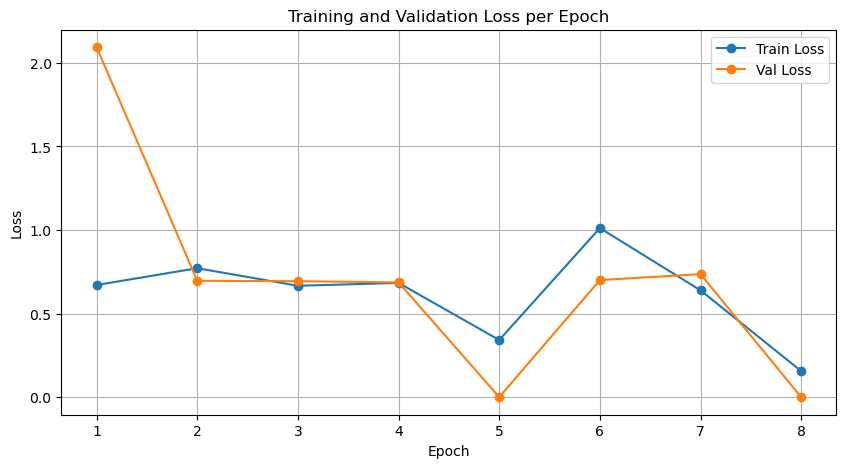

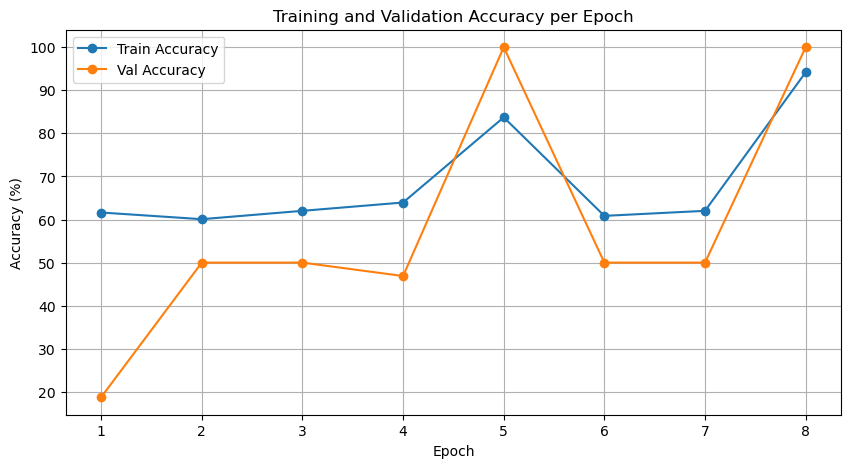

In [29]:
import matplotlib.pyplot as plt

epochs = list(range(1, 9))  # Since you have 8 epochs

# Loss plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_loss.png')
plt.show()

# Accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(epochs, val_accuracies, marker='o', label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_accuracy.png')
plt.show()

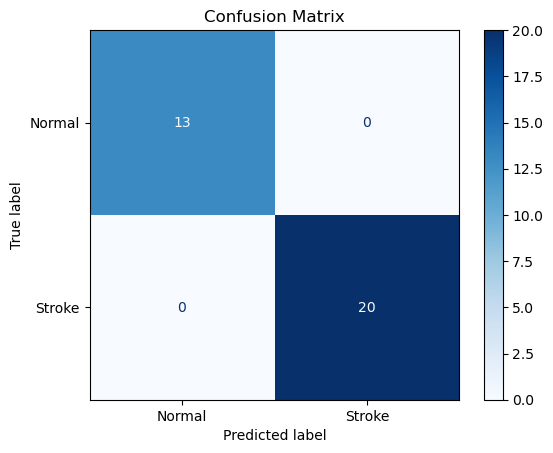

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Paste the values you shared
y_true = [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1]
y_pred = [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1]

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Stroke"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig('3DCM.png')
plt.show()